# AI for Seamless Travel Planning & Recommendations 

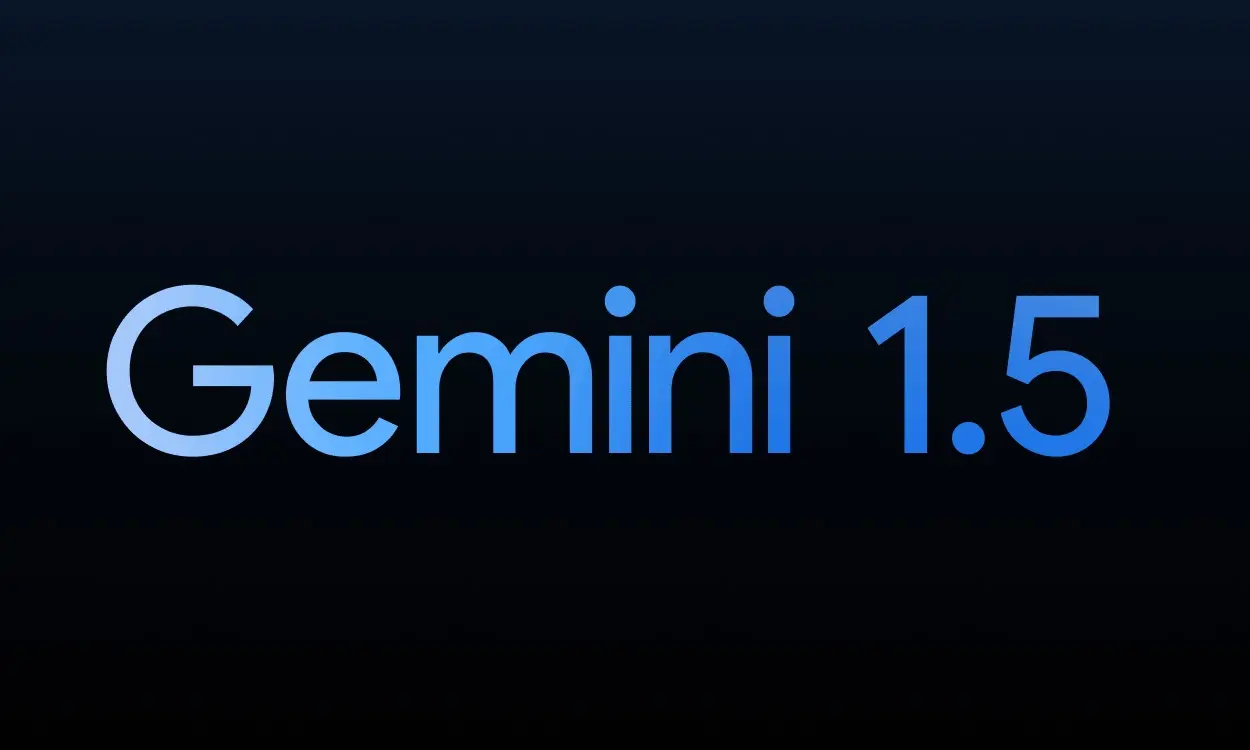

# 1. Background

## Project Description:

This project leverages advanced AI technologies to create a seamless and personalized travel experience. Key features include:
1. **Travel Places Recommendation**: Using a recommendation model, the system suggests travel destinations based on user preferences and historical data, offering tailored travel options for every user.
2. **Travel Itinerary Planning**: Powered by Gemini Long Context, the platform generates detailed and personalized travel itineraries, helping users plan their trips efficiently by considering multiple destinations and activities.
3. **Accommodations & Travel Agents**: For every prepared travel plan, the system provides curated recommendations for accommodations and travel agents, utilizing Gemini Context Caching to ensure fast, accurate, and up-to-date responses.
4. **Travel Chatbot with Context Caching**: The user-friendly chatbot is designed to provide accurate real-world data, leveraging context caching to assist users effectively. I utilized Gemini 1.5 Pro here, which offers robust long context support.

This implementation is designed specifically for travelers exploring Sri Lanka, one of the world’s most captivating destinations. Known for its stunning landscapes, rich cultural heritage, and diverse wildlife, Sri Lanka is a top contender in global tourism rankings. With its beautiful beaches, historical sites, lush tea plantations, and vibrant festivals, it offers something for every type of traveler.


Sri Lanka’s pristine beaches are perfect for relaxation and adventure.

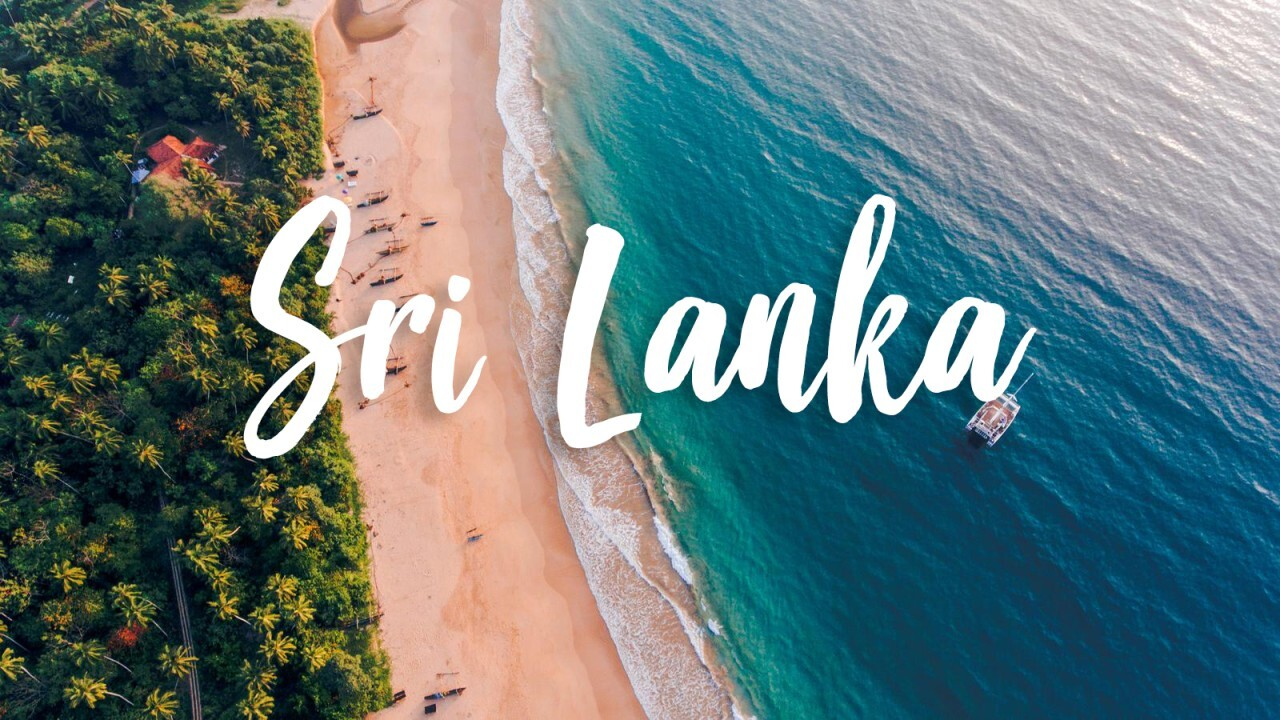

## Why Travel to Sri Lanka?
* **World-Renowned Tourist Attractions**: Sri Lanka is home to iconic attractions such as the ancient city of Anuradhapura, the breathtaking Sigiriya Rock Fortress, and the picturesque Ella Gap.
* **Diverse Natural Beauty**: From tropical rainforests and serene beaches to rolling tea plantations in the Hill Country, Sri Lanka’s natural beauty is unmatched.
* **Cultural Heritage**: Sri Lanka boasts a rich history with UNESCO World Heritage Sites, temples, and vibrant cultural festivals like Kandy Esala Perahera.
* **Wildlife and Adventure**: The island’s national parks, such as Yala and Udawalawe, are perfect for wildlife enthusiasts and adventurers.

**Sri Lanka’s Growing Tourism Ranking**:
Sri Lanka is increasingly recognized as one of the best travel destinations globally, offering diverse experiences, from luxury resorts to backpacking tours, all amidst a welcoming and friendly local culture. The country's tourism is expanding, and it’s poised to become a hub for international travelers seeking both relaxation and adventurrs.

## Why This Implementation Is Important

* **All-in-One Solution**: This platform simplifies travel to Sri Lanka by offering everything in one place—recommendations, itinerary planning, accommodation options, and local travel agents—making travel planning easier and faster.
* **Simplicity & Convenience**: The user-friendly interface ensures that even first-time travelers can easily navigate through their travel plans, with no complex processes to follow.
* **Interactive & Personalized**: The fine-tuned RAG-based chatbot provides real-time support, answering questions and providing tailored travel recommendations based on individual preferences.
* Boosting Tourism: By offering a seamless and attractive travel experience, this implementation can help attract more tourists to Sri Lanka, highlighting the island's natural beauty, cultural richness, and hospitality in a modern, tech-driven way.
way.

# 2. Implementation

In [208]:
pip install genai

In [174]:
import google.generativeai as genai
import os
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations, permutations
import ast
import time
import dill
from httpx import HTTPStatusError
import tempfile

In [178]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
key_1 = user_secrets.get_secret("gemini api key 1")
key_2 = user_secrets.get_secret("gemini api key 2")

In [179]:
#Setup for Travel planner
genai.configure(api_key=key_2)

generation_config1 = {
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 64,
    "max_output_tokens": 20240,
    "response_mime_type": "text/plain",
}

model1 = genai.GenerativeModel(
    model_name="gemini-1.5-flash",
    generation_config=generation_config1,
)

### Below I load my recommendation model built in following notebook: 

https://www.kaggle.com/code/akinduhiman/travel-recommendation-model 


> In that notebook, I also used Gemini 1.5 Flash for data preprocessing.  The long context window support was much needed there too. 


In [194]:
pkl_path = r"/kaggle/input/recommendation-model/other/default/1/Recommendation Model.pkl"
with open(pkl_path, 'rb') as file:
    loaded_recommender = dill.load(file)

In [195]:
# Extract itinerary details from the response
def extract_itinerary_details(text):
    days = re.split(r'Day \d+:', text)[1:]
    itinerary = {}
    for i, day in enumerate(days, 1):
        day_title = re.search(r'(.*?)\n', day.strip()).group(1).strip().replace('[', '').replace(']', '').replace('*', '')
        day_key = f"Day {i}: {day_title}"

        description_match = re.search(r'Description:\s*(.*?)(?=\n-\s*Activities:|\Z)', day, re.DOTALL)
        description = description_match.group(1).strip() if description_match else ""

        activities_match = re.search(r'Activities:\s*(.*?)(?=\Z)', day, re.DOTALL)
        activities = activities_match.group(1).strip().split('|') if activities_match else []
        activities = [activity.strip().lstrip('-,') for activity in activities if activity.strip()]

        itinerary[day_key] = {
            'Description': description,
            'Activities': activities
        }

    return itinerary

In [196]:
# Process locations from the itinerary
def process_locations(itinerary):
    Locations = [day.split(':')[1].strip() for day in itinerary.keys()]
    expanded_loc = []
    for item in Locations:
        if '-' in item:
            parts = [part.strip().replace('[', '').replace(']', '').replace('*', '') for part in item.split('-')]
            expanded_loc.extend(parts)
        else:
            expanded_loc.append(item.replace('[', '').replace(']', '').replace('*', ''))

    unique_loc = []
    previous_item = None
    for item in expanded_loc:
        if item != previous_item:
            unique_loc.append(item)
        previous_item = item

    return unique_loc

In [197]:
# Recommend places based on user's activities and bucket list
def recommend(user_activities, user_bucket_list):
    try:
        print("user_activities: ", user_activities)
        print("user_bucket_list: ", user_bucket_list)

        if not isinstance(user_activities, list) or not isinstance(user_bucket_list, list):
            print("Invalid input format")
            return None

        recommended_places = loaded_recommender.recommend_top_places(user_activities, user_bucket_list)
        print("recommended_places: ", recommended_places)
        
        return recommended_places
    except Exception as e:
        print("Error:", str(e))
        return None

### Gemini set up to generate the travel plan 

In [198]:
# Generate itinerary for the user
def generate_itinerary(selected_categories, recommended_places, duration):
    try:
        print("recommended_places: ", recommended_places)
        print("selected_categories: ", selected_categories)
        print("duration: ", duration)

        response = model1.generate_content(f"[AI Role: Trip planning expert inside Sri Lanka]\n"
                                             f"Travel places: {recommended_places}\n"
                                             f"A tourist who is in love with {selected_categories} wants to travel to various destinations in Sri Lanka. "
                                             f"Based on the Travel places provided. Create a {duration} -day travel plan that starts and ends at BIA Airport "
                                             f"with minimizing the travel distance whenever it can also need to minimize the travel distance. "
                                             f"The plan should recommend the best matching places to visit, where to stay each night, and what to do each day. "
                                             f"Ensure that the plan fits within the {duration} days available. \n \n"
                                             f"Format the output as follows, without using any markdown syntax: \n \n"
                                             f"Day number(only one date): Place where the tourist stays in that day, if there are many separate using '-' \n"
                                             f"- Description:  \n"
                                             f"- [Little description to the day start and end of the day] \n"
                                             f"- Activities:  \n"
                                             f"- [Suggest some activities(maximum 5) separated by '|' sign (Only that don't add any other)] \n"
                                             f"Please provide a detailed itinerary that ensures the tourist has a fulfilling experience each day, ")

        print("\n\nresponse.text: ", response.text)
        itinerary = extract_itinerary_details(response.text)
        expanded_loc = process_locations(itinerary)

        return {'itinerary': itinerary, 'expanded_loc': expanded_loc}
    except Exception as e:
        print("Error:", str(e))
        return None

In [199]:
# List of all available activities
activities_list = [
    'Amusement Parks', 'Animal Encounters', 'Archaeological Sites', 'Architecture Photography',
    'Architecture Tours', 'Art Classes', 'Arts and Culture', 'Ayurvedic Spa Treatments',
    'Beach Visits', 'Beachfront Dining', 'Bird Watching', 'Boat Safaris', 'Botanical Gardens',
    'Butterfly Watching', 'Camping', 'Caving', 'City Tours', 'Craft Workshops',
    'Cultural Experiences', 'Cultural Festivals', 'Cycling', 'Elephant Rides', 'Fishing',
    'Golfing', 'Hiking', 'Historic Sites', 'Historic Walks', 'Historical Monuments',
    'History Tours', 'Horse Shows', 'Horseback Riding', 'Hot Air Ballooning', 'Hot Springs',
    'Kayaking', 'Landscape Photography', 'Literary Tours', 'Local Crafts', 'Mountain Biking',
    'Museum Visits', 'Outdoor Adventures', 'Paddleboarding', 'Photography',
    'Planetarium Visits', 'Public Art Installations', 'River Cruises', 'Rock Climbing',
    'Safaris', 'Sailing', 'Sailing Lessons', 'Scuba Diving', 'Sea Cruises', 'Sightseeing',
    'Snorkeling', 'Spiritual Retreats', 'Surfing', 'Tea Tasting', 'Temple Pilgrimages',
    'Theater', 'Themed Parks', 'Traditional Ceremonies', 'Turtle Watching', 'Village Homestays',
    'Water Parks', 'Waterfalls', 'Whale Watching', 'Wildlife Viewing', 'Yoga Retreats',
    'Zip-lining'
]

print("Available activities:")
for i, activity in enumerate(activities_list, 1):
    print(f"{i}. {activity}")

Available activities:
1. Amusement Parks
2. Animal Encounters
3. Archaeological Sites
4. Architecture Photography
5. Architecture Tours
6. Art Classes
7. Arts and Culture
8. Ayurvedic Spa Treatments
9. Beach Visits
10. Beachfront Dining
11. Bird Watching
12. Boat Safaris
13. Botanical Gardens
14. Butterfly Watching
15. Camping
16. Caving
17. City Tours
18. Craft Workshops
19. Cultural Experiences
20. Cultural Festivals
21. Cycling
22. Elephant Rides
23. Fishing
24. Golfing
25. Hiking
26. Historic Sites
27. Historic Walks
28. Historical Monuments
29. History Tours
30. Horse Shows
31. Horseback Riding
32. Hot Air Ballooning
33. Hot Springs
34. Kayaking
35. Landscape Photography
36. Literary Tours
37. Local Crafts
38. Mountain Biking
39. Museum Visits
40. Outdoor Adventures
41. Paddleboarding
42. Photography
43. Planetarium Visits
44. Public Art Installations
45. River Cruises
46. Rock Climbing
47. Safaris
48. Sailing
49. Sailing Lessons
50. Scuba Diving
51. Sea Cruises
52. Sightseeing
53

## Travel Places Recommendation

In [200]:
#### Get user preferred activities (max 3)
user_activities = []
while len(user_activities) < 3:
    try:
        activity_num = int(input(f"\nEnter activity number (1-{len(activities_list)}) or 0 to finish: "))
        if activity_num == 0:
            if len(user_activities) == 0:
                print("Please select at least one activity")
                continue
            break
        if 1 <= activity_num <= len(activities_list):
            activity = activities_list[activity_num-1]
            if activity not in user_activities:
                user_activities.append(activity)
                print(f"Added: {activity}")
            else:
                print("Activity already selected")
        else:
            print("Invalid activity number")
    except ValueError:
        print("Please enter a valid number")

# Get bucket list destinations (max 5)
print("\nEnter up to 5 destinations for your bucket list (one per line)")
print("Press Enter twice to finish")
user_bucket_list = []
while len(user_bucket_list) < 5:
    destination = input().strip()
    if not destination:
        if len(user_bucket_list) == 0:
            print("Please enter at least one destination")
            continue
        break
    user_bucket_list.append(destination)

# Call recommend function with user inputs
recommended_places = recommend(user_activities, user_bucket_list)


Enter activity number (1-68) or 0 to finish:  9


Added: Beach Visits



Enter activity number (1-68) or 0 to finish:  40


Added: Outdoor Adventures



Enter activity number (1-68) or 0 to finish:  55


Added: Surfing

Enter up to 5 destinations for your bucket list (one per line)
Press Enter twice to finish


 negombo
 galle
 


user_activities:  ['Beach Visits', 'Outdoor Adventures', 'Surfing']
user_bucket_list:  ['negombo', 'galle']
recommended_places:  ('Corbetts Gap', 'Hambantota Beach', 'Tangalle', 'Weligama Beach surf and stay', 'Ahangama')


## Travel Itinerary Planning

In [201]:
# Get travel duration from user
while True:
    try:
        duration = int(input("\nEnter number of days for your trip (1-31): "))
        if 1 <= duration <= 31:
            break
        print("Please enter a duration between 1 and 14 days")
    except ValueError:
        print("Please enter a valid number")

# Generate itinerary using the collected inputs
itinerary_result = generate_itinerary(user_activities, recommended_places, duration)

if itinerary_result:
    # print("\nGenerated Itinerary:")
    # print(itinerary_result['itinerary'])
    print("\nExpanded Locations:")
    print(itinerary_result['expanded_loc'])
else:
    print("\nFailed to generate itinerary. Please try again.")


Enter number of days for your trip (1-31):  7


recommended_places:  ('Corbetts Gap', 'Hambantota Beach', 'Tangalle', 'Weligama Beach surf and stay', 'Ahangama')
selected_categories:  ['Beach Visits', 'Outdoor Adventures', 'Surfing']
duration:  7


response.text:  Day 1: BIA Airport - Negombo
- Description: Arrive at Bandaranaike International Airport (BIA), Colombo. Transfer to Negombo, a coastal town known for its beaches and seafood. Check into your hotel and relax.
- Activities: Relax on Negombo Beach | Explore Negombo Fish Market | Enjoy a seafood dinner

Day 2: Negombo - Weligama Beach surf and stay
- Description:  Morning travel to Weligama. Weligama is renowned for its beginner-friendly surf breaks. Check into your surf and stay accommodation.
- Activities:  Beginners surf lesson | Relax on Weligama Beach | Enjoy sunset views from the beach | Explore the local town

Day 3: Weligama Beach surf and stay
- Description: Full day dedicated to surfing and enjoying the beach.
- Activities: Surf lessons | Practice surfing | Relax on

## Accommodations & Travel Agents - Context Caching in Action

In [202]:
# Define file paths
file_paths = {
    "Bungalows": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_bungalows.txt",
    "Camping Sites": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_camping_sites.txt",
    "Home Stays": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_home_stays.txt",
    "Normal Hotels": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_normal_hotels.txt",
    "Star Hotels": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_star_class_hotels.txt",
    "Boutique Villas": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_boutique_villas.txt",
    "Sri Lanka Tourism Resorts": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_sri_lanka_tourism_resorts.txt",
    "travel_agents": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Agents/combined_travel_agents.txt"
}

# Create a dictionary to store the content of each file
file_contents = {}

# Loop through the file paths and read their contents
for name, path in file_paths.items():
    with open(path, 'r', encoding='utf-8') as file:
        file_contents[name] = file.read()

In [203]:
import datetime

def create_generative_model(files):
    genai.configure(api_key=key_2)
    # Create cached content
    cached_content = genai.caching.CachedContent.create(
        model="gemini-1.5-flash-002",
        system_instruction="""
            You are a travel accommodation and travel agent expert in Sri Lanka.
            Your job is to give accommodations and travel agents for user input locations
        """,
        contents=files,
        ttl=datetime.timedelta(minutes=60),
        display_name="Travel_cache",
    )
    
    # Define generation configuration
    generation_config2 = {
        "temperature": 1,
        "top_p": 0.95,
        "top_k": 10,
        "max_output_tokens": 10000,
        "response_mime_type": "application/json"
    }
    
    # Create and return the generative model
    model = genai.GenerativeModel(
        model_name="gemini-1.5-pro-002",
        generation_config=generation_config2,
    ).from_cached_content(cached_content=cached_content)
    
    return model


In [204]:
import asyncio  # Required for asynchronous execution

# Read files dynamically
def load_selected_accommodations(selected_accommodations):
    files = []
    for accommodation_type in selected_accommodations:
        file = file_contents[accommodation_type]
        files.append(file)
    files.append(file_contents["travel_agents"])  # Add travel agents data
    return files

# Updated get_accommodations function
async def get_accommodations(expanded_loc, selected_accommodations):
    """
    Fetch accommodations and travel agent recommendations for specified locations.

    Args:
        expanded_loc (str): Locations to query.
        selected_accommodations (list): Types of accommodations to include.

    Returns:
        str: JSON string response with recommendations or None if an error occurs.
    """
    try:
        print("\nExpanded Location:", expanded_loc)
        print("\nSelected Accommodations:", selected_accommodations)
        
        # Load files based on the selected accommodations
        files = load_selected_accommodations(selected_accommodations)
        if not files:
            print("No files loaded for the selected accommodations.")
            return None
        
        # Create the model with the loaded files
        model = create_generative_model(files)

        # Build the final prompt
        final_prompt = f"""Role: You are a travel location expert in Sri Lanka.
                        Use the given accommodations available to provide the best accommodation options and travel agents for each unique location (include full information about the accommodation like the name of the hotel, the location, the rating, and the contact numbers): {expanded_loc}

                        The return format must be in valid JSON format only. Do not add any other text. The structure should be as follows:

                        {{
                            "locations": [
                                {{
                                    "name": "location name",
                                    "accommodations": [
                                        {{
                                            "name": "Name of the hotel",
                                            "type": "Accommodation type", 
                                            "contact": {{
                                                "phone": "phone number",
                                                "email": "email",
                                                "website": "website"
                                            }}
                                        }}
                                    ],
                                    "travel_agents": [
                                        {{
                                            "name": "Name of travel agent",
                                            "contact": {{
                                                "phone": "phone number",
                                                "email": "email",
                                                "website": "website"
                                            }}
                                        }}
                                    ]
                                }}
                            ]
                        }}

                        If there are no accommodations available in the location, then don't add that location to the response.

                        Ensure the response is user-friendly and attractive.

                        Important: The response must be valid JSON. Do not include any explanatory text outside the JSON structure."""

        print("\nFinal Prompt Length (Tokens):", model.count_tokens(final_prompt))

        try:
            response = await asyncio.wait_for(
                model.generate_content_async(final_prompt), 
                timeout=5000,  
            )
            return response.text
        except asyncio.TimeoutError:
            print("Error: Generation timed out.")
            return None

    except Exception as e:
        print("Error:", e)
        return None


In [205]:
# List of accommodation options
accommodation_options = [
    'Star Hotels',
    'Normal Hotels', 
    'Sri Lanka Tourism Resorts',
    'Boutique Villas',
    'Bungalows',
    'Home Stays',
    'Camping Sites'
]

# Get user input for preferred accommodations
print("Please select your preferred accommodation types (enter numbers separated by spaces):")
for i, option in enumerate(accommodation_options, 1):
    print(f"{i}. {option}")

# Get user input and validate
while True:
    try:
        selections = input("\nEnter your choices (e.g. 1 3 4): ").split()
        selected_indices = [int(x) - 1 for x in selections]
        
        # Validate indices
        if all(0 <= idx < len(accommodation_options) for idx in selected_indices):
            selected_accommodations = [accommodation_options[idx] for idx in selected_indices]
            break
        else:
            print("Invalid selection. Please enter valid numbers.")
    except ValueError:
        print("Invalid input. Please enter numbers only.")

# Example locations (replace with actual locations)
expanded_loc = itinerary_result['expanded_loc']

# Call get_accommodations with selected options
result = await get_accommodations(expanded_loc, selected_accommodations)
print("\nResponse taken successfully")

Please select your preferred accommodation types (enter numbers separated by spaces):
1. Star Hotels
2. Normal Hotels
3. Sri Lanka Tourism Resorts
4. Boutique Villas
5. Bungalows
6. Home Stays
7. Camping Sites



Enter your choices (e.g. 1 3 4):  1 2 3 4 5 6



Expanded Location: ['BIA Airport', 'Negombo', 'Weligama Beach surf and stay', 'Ahangama', 'Tangalle', 'Hambantota Beach', 'BIA Airport']

Selected Accommodations: ['Star Hotels', 'Normal Hotels', 'Sri Lanka Tourism Resorts', 'Boutique Villas', 'Bungalows', 'Home Stays']

Final Prompt Length (Tokens): total_tokens: 94519
cached_content_token_count: 94157


Response taken successfully


## Why context caching
Here context caching accelerates subsequent requests by processing only new inputs, such as additional locations, while reusing previously cached data. This approach ensures consistent and reliable handling of accommodations and travel agents, minimizing redundant computations. By reducing resource usage and response times, it enhances efficiency and cost-effectiveness, making it ideal for managing large datasets in travel-related applications.

In [206]:
# print("Accommodation Results:")
accommodation_details = result
# accommodation_details

### Let's see final results at one glance

In [207]:
import json

def print_travel_plan(itinerary, response):
    print("\n=== Your Personalized Travel Plan ===\n")
    
    # Print itinerary details
    for day, details in itinerary.items():
        print(f"\n{day.upper()}")
        print("=" * len(day))
        print(f"Staying at: {day.split(':')[1].strip()}")
        print(f"\nDescription:")
        print(details['Description'])
        print("\nRecommended Activities:")
        for activity in details['Activities']:
            print(f"• {activity.strip()}")
        print("-" * 50)

    # Print accommodation details
    print("\n=== Available Accommodations and Travel Agents by Location ===\n")
    
    # Parse response to JSON if it's a string
    if isinstance(response, str):
        try:
            # Remove ```json and ``` if present
            if response.startswith('```json'):
                response = response[7:]
            if response.endswith('```'):
                response = response[:-3]
            else:
                response = response[:-4]
            data = json.loads(response)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {str(e)}")
            print("Raw response:", response)
            return
    else:
        data = response

    # Process accommodations and travel agents data
    if isinstance(data, dict):
        for location in data.get('locations', []):
            print(f"\n{location['name'].upper()}")
            print("=" * len(location['name']))
            
            # Print accommodations
            accommodations = location.get('accommodations', [])
            if accommodations:
                print("\nAccommodations:")
                for acc in accommodations:
                    name = acc.get('name', 'N/A')
                    acc_type = acc.get('type', 'N/A').replace('_', ' ').title()
                    print(f"\n• {name} ({acc_type})")
                    
                    # Only print contact section if there is contact info
                    contact = acc.get('contact', {})
                    has_contact = any(v for v in contact.values() if v is not None)
                    
                    if has_contact:
                        print("  Contact Information:")
                        if contact.get('phone'):
                            print(f"    - Phone: {contact['phone']}")
                        if contact.get('email'):
                            print(f"    - Email: {contact['email']}")
                        if contact.get('website'):
                            print(f"    - Website: {contact['website']}")

            # Print travel agents
            agents = location.get('travel_agents', [])
            if agents:
                print("\nTravel Agents:")
                for agent in agents:
                    name = agent.get('name', 'N/A')
                    print(f"\n• {name}")
                    
                    contact = agent.get('contact', {})
                    has_contact = any(v for v in contact.values() if v is not None)
                    
                    if has_contact:
                        print("  Contact Information:")
                        if contact.get('phone'):
                            print(f"    - Phone: {contact['phone']}")
                        if contact.get('email'):
                            print(f"    - Email: {contact['email']}")
                        if contact.get('website'):
                            print(f"    - Website: {contact['website']}")
            print("-" * 50)
    else:
        print(f"Invalid data format. Expected dictionary, got {type(data)}")
        print("Raw data:", data)

# Print the formatted results
print_travel_plan(itinerary_result['itinerary'], result)



=== Your Personalized Travel Plan ===


DAY 1: BIA AIRPORT - NEGOMBO
Staying at: BIA Airport - Negombo

Description:
Arrive at Bandaranaike International Airport (BIA), Colombo. Transfer to Negombo, a coastal town known for its beaches and seafood. Check into your hotel and relax.

Recommended Activities:
• Relax on Negombo Beach
• Explore Negombo Fish Market
• Enjoy a seafood dinner
--------------------------------------------------

DAY 2: NEGOMBO - WELIGAMA BEACH SURF AND STAY
Staying at: Negombo - Weligama Beach surf and stay

Description:
Morning travel to Weligama. Weligama is renowned for its beginner-friendly surf breaks. Check into your surf and stay accommodation.

Recommended Activities:
• Beginners surf lesson
• Relax on Weligama Beach
• Enjoy sunset views from the beach
• Explore the local town
--------------------------------------------------

DAY 3: WELIGAMA BEACH SURF AND STAY
Staying at: Weligama Beach surf and stay

Description:
Full day dedicated to surfing and enj

## Travel Chatbot powered by context caching

In [175]:
# Define file paths
file_paths = {
    "Bungalows": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_bungalows.txt",
    "Camping Sites": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_camping_sites.txt",
    "Home Stays": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_home_stays.txt",
    "Normal Hotels": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_normal_hotels.txt",
    "Star Hotels": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_star_class_hotels.txt",
    "Boutique Villas": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_boutique_villas.txt",
    "Sri Lanka Tourism Resorts": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Places_to_stay/combined_sri_lanka_tourism_resorts.txt",
    "travel_agents": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Agents/combined_travel_agents.txt",
    "tour_guides": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Agents/combined_tour_guides.txt",
    "taxi_operator": "/kaggle/input/gemini-long-context-dataset/Documents/Transport/taxi_opperator.txt",
    "airports": "/kaggle/input/gemini-long-context-dataset/Documents/Transport/airports.txt",
    "air_taxi": "/kaggle/input/gemini-long-context-dataset/Documents/Transport/air_taxi.txt",
    "tourist_shops": "/kaggle/input/gemini-long-context-dataset/Documents/Combined_Resourses/Shops/combined_tourist_shops.txt",
    "activities": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/activities.txt",
    "accommodation": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/accommodation.txt",
    "about_sri_lanka": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/about-sri-lanka.txt",
    "directors": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/Directors.txt",
    "board": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/Board.txt",
    "adventure_sports": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/adventure-sports.txt",
    "bliss_nature_trails": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/bliss-nature-trails.txt",
    "before_you_go": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/before-you-go.txt",
    "authorized_tuk_tuk_drivers": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/authorized-tuk-tuk-drivers.txt",
    "authorized_tourist_drivers": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/authorized-tourist-drivers.txt",
    "attractions": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/attractions.txt",
    "eco_tourism": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/eco-tourism.txt",
    "eating_places": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/eating-places.txt",
    "contributing_bloggers": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/contributing_bloggers.txt",
    "colombo_city_tour": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/colombo-city-tour.txt",
    "careers": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/careers.txt",
    "night_life": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/night-life.txt",
    "history": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/history.txt",
    "getting_around": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/getting-around.txt",
    "gemstone_srilanka": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/gemstone-srilanka.txt",
    "foreign_embassies": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/foreign-embassies.txt",
    "flight_booking": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/flight-booking.txt",
    "festive": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/festive.txt",
    "essence": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/essence.txt",
    "emergency_services": "/kaggle/input/gemini-long-context-dataset/Documents/scraped_texts/emergency-services.txt"
}

# Create a dictionary to store the content of each file
file_contents = {}

# Loop through the file paths and read their contents
for name, path in file_paths.items():
    with open(path, 'r', encoding='utf-8') as file:
        file_contents[name] = file.read()


In [186]:
import datetime

# Function to load file contents
def load_files(file_paths):
    files = []
    for name, path in file_paths.items():
        with open(path, 'r', encoding='utf-8') as file:
            readed_file = file.read()
            files.append(readed_file)
    return files
    
def create_chat_model(file_paths):
    # Load all files into the files variable
    files = load_files(file_paths)
    
    genai.configure(api_key=key_1)
    
    # Create cached content
    cached_content = genai.caching.CachedContent.create(
        model="gemini-1.5-flash-002",
        system_instruction="""
            You are a travel guiding expert in Sri Lanka.
            Your job is to give answers to user inputs.
        """,
        contents=files,  # Pass the loaded files here
        ttl=datetime.timedelta(minutes=20),
        display_name="Travel_cache",
    )
    
    # Define generation configuration
    generation_config2 = {
        "temperature": 1,
        "top_p": 0.95,
        "top_k": 10,
        "max_output_tokens": 5000,
        "response_mime_type": "text/plain"
    }
    
    # Create and return the generative model
    model = genai.GenerativeModel(
        model_name="gemini-1.5-pro-002",
        generation_config=generation_config2,
    ).from_cached_content(cached_content=cached_content)
    
    return model

# Create the model with the specified file paths
chat_model = create_chat_model(file_paths)

In [191]:
chat_session = chat_model.start_chat()

In [192]:
# Create an interactive chat loop
while True:
    # Get user input
    user_message = input("\nYou: ")
    print("User:" + user_message)
    print("\n")
    
    # Exit condition
    if user_message.lower() in ['quit', 'exit', 'bye']:
        print("\nBot: Goodbye! Have a great day!")
        break

    # print("\nFinal Prompt Length (Tokens):", model.count_tokens(final_prompt))
        
    # Get response from chat function
    result = chat_session.send_message(user_message)
    
    if result:
        # Print response
        print(f"Bot: {result.text}")
        print("-------------------------------------------------------------------------")
    else:
        print("\nBot: I'm sorry, I encountered an error. Please try again.")



You:  Hi


User:Hi


Bot: Hello there! How can I help you plan your trip to Sri Lanka?

-------------------------------------------------------------------------



You:  I am planning a trip but don't know anyone in Sri lanka, Can you give me short list of details about travel agents in colombo


User:I am planning a trip but don't know anyone in Sri lanka, Can you give me short list of details about travel agents in colombo


Bot: Certainly!  I can provide you with a short-list of travel agents in Colombo.  However, keep in mind that I don't have access to real-time information, including business status or current contact details.  Always verify information independently before making any bookings.  Also, the "best" agent depends on your specific needs and travel style (luxury, budget, adventure, etc.).

Here's a small selection of Colombo-based travel agents from my data, which you should verify independently:


* **A & A Travels (pvt) Ltd:**  Known for its website, www.anasrilanka.com.  Check their website for contact details and services.

* **Atlas Lanka (pvt) Ltd:** Has a website, www.atlaslanka.com. Verify their contact information and offered packages.

* **Atro Holidays (private) Limited:**  Website is www.atroholidays.com. Check for up-to-date details.

* **Avro Trav


You:  Thats cool, Do you know anything about transportation in colombo


User:Thats cool, Do you know anything about transportation in colombo


Bot: Colombo's transportation system is a mix of modern and traditional options, each with its own advantages and disadvantages. Here's a summary:

**1. Three-Wheelers (Tuk-Tuks):**

* **Pros:** Iconic, readily available, relatively inexpensive for short distances, good for navigating congested areas.
* **Cons:** Not metered (negotiate fare beforehand!), safety can be a concern (especially at night), not ideal for long distances or luggage.

**2. Taxis:**

* **Pros:** Metered (in theory – check meter is working!), readily available, better safety than tuk-tuks. Apps like PickMe are available for safer, pre-booked rides.
* **Cons:** Can be expensive, especially during peak hours or for long distances. Traffic congestion adds significantly to travel times.

**3. Buses:**

* **Pros:** Cheapest option, extensive network covering most areas of Colombo.
* **Cons:** Can be crowded and uncomfortable, especially during peak


You:  Nice, I think now I am confident enough to go. Recommend me a beach in the first instance after going there 


User:Nice, I think now I am confident enough to go. Recommend me a beach in the first instance after going there 


Bot: That's great to hear you're feeling more confident about your trip!  Recommending a beach depends on what kind of beach experience you're looking for. To give you the best suggestion, tell me:

* **What kind of atmosphere are you looking for?** (Relaxed and quiet, lively and bustling, family-friendly, romantic, etc.)
* **What are your priorities?** (Swimming, sunbathing, watersports, surfing, nightlife, etc.)
* **How far from Colombo are you willing to travel?** (Some beaches are closer than others).

Once I have this information, I can give you a much more tailored and helpful recommendation.

-------------------------------------------------------------------------



You:  I prefer Relaxed and quiet one


User:I prefer Relaxed and quiet one


Bot: Okay, for a relaxed and quiet beach experience in Sri Lanka, I'd recommend considering these options, keeping in mind that even "quiet" beaches can get busier on weekends and holidays:

* **Negombo Beach (less busy sections):** While Negombo is known for its bustling town, you can find quieter stretches of the beach, particularly towards the north or south ends, away from the main tourist areas.  It's relatively close to Colombo, making it convenient.

* **Mount Lavinia Beach (off-peak times):** Similar to Negombo, Mount Lavinia can be busy but is a beautiful beach with a more relaxed atmosphere than some others. Visiting during the week or off-peak hours will increase your chances of a quieter experience.

* **Bentota Beach (less crowded areas):** Bentota is popular, but it's a long beach, so you can explore quieter stretches away from the main hotels and resorts.


To help me narrow it down further, could you tell me:

* **Your preferred lev


You:  bye


User:bye



Bot: Goodbye! Have a great day!


In [193]:
print(f"Total Prompt Length (Token count): total_tokens: {result.usage_metadata.total_token_count}")
print(f"\nCached Length (Token count): total_tokens: {result.usage_metadata.cached_content_token_count}")

Total Prompt Length (Token count): total_tokens: 688812

Cached Length (Token count): total_tokens: 687417


## Why context caching
Building a chatbot of this complexity traditionally required extensive Retrieval-Augmented Generation (RAG) systems to fine-tune the model for handling large datasets effectively. However, with context caching support, this additional overhead is no longer necessary. Context caching enables the reuse of previously processed information, reducing the need to repeatedly prompt external data.

This approach not only simplifies implementation but also saves a significant number of tokens during model interactions—ultimately cutting down on costs. Tokens saved are money saved, making context caching a game-changer for cost-efficient and scalable chatbot solutions.

# 3. Conclusion 

## Gemini’s Long Context: The Secret to Better Travel Recommendations

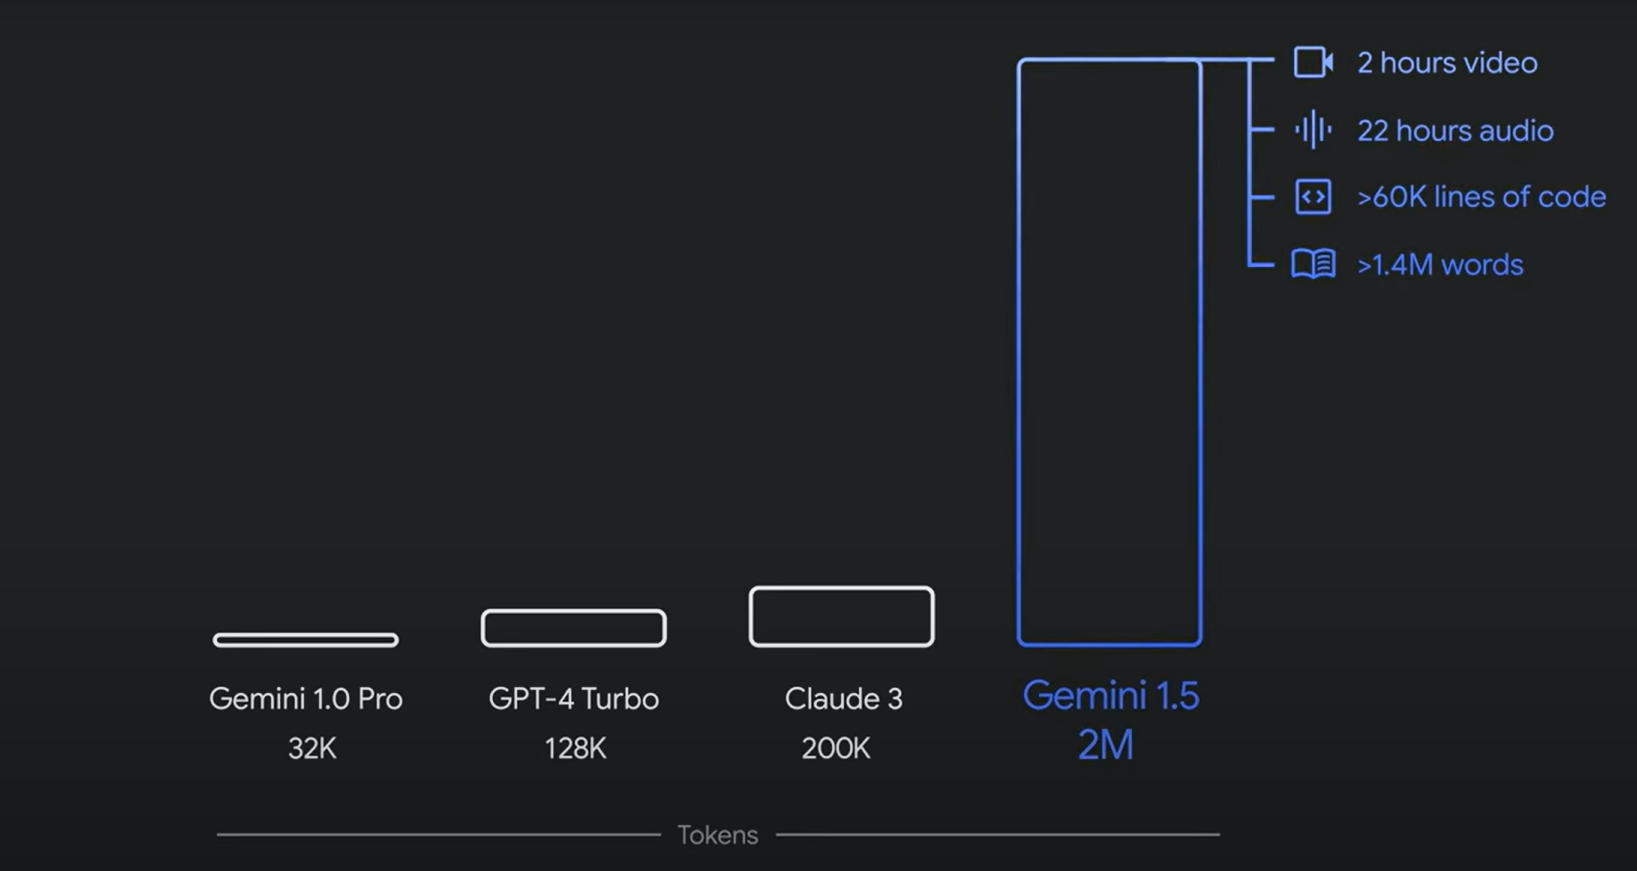

The long context window support in Gemini 1.5 Flash was instrumental in enabling several key aspects of my project:

1. **Data Preprocessing in Travel Recommendation Model Creation**:While analyzing user reviews and preferences across a large dataset of locations, the extended context window allowed us to efficiently process and integrate diverse information. This ensured personalized and accurate recommendations for travelers.
2. **Travel Itinerary Planning**:Handling complex multi-location itineraries required processing detailed data about destinations, activities, and preferences. The long context window facilitated seamless analysis of all this information, resulting in comprehensive and personalized travel plans.
3. **Accommodations & Travel Agents**:When selecting the most suitable accommodations and travel agents for users, the system analyzed vast datasets. The long context capabilities enabled accurate retrieval and matching to user preferences, ensuring relevance and efficiency.
4. **Travel Chatbot with Context Caching**: The chatbot utilizes Gemini 1.5 Pro with long context support to provide accurate, real-world data, effectively assisting users in need. By leveraging context caching, the chatbot can access and process a large external dataset for travel-related queries without the traditional overhead of extensive Retrieval-Augmented Generation (RAG) systems.

References:

Official Sri Lanka Tourism Website: www.srilanka.travel

Location Data and Maps: Google Maps